This notebook estimates the curve shape relating a feature of interest (e.g. word surprisal) and average/peak amplitude for the given ERPs, given a trained Cannon model.

In [1]:
import io
from itertools import product
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import torch
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
from berp.models import load_model
import berp.trainer  # good yaml defaults
from berp.viz.trf import plot_trf_coefficients
from berp.viz.trf_em import pipeline_to_dataframe, aggregate_cannon_coef_df

In [4]:
workflow = "heilbron2022"
lm = "EleutherAI/gpt-neo-2.7B/n10000"

paradigm = "cannon_wide"
cannon_run_name = "trf-berp-cannon_3quantiles.29720801"
# cannon_run_name = "trf-berp-cannon_5quantiles"
# cannon_run_name = "trf-berp-cannon_4quantiles"
# cannon_run_name = "trf-cannon_10quantiles"

# Safe to load just one subject -- we only are investigating stimulus differences here
subjects = [1]
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

# target_sensors = ["B19", "B20", "B22"]
target_sensors = ['B22', 'D19', 'A19', 'C22', 'C10', 'C32', 'A7', 'B4']

normalize_X_ts = False
normalize_X_variable = True
normalize_Y = False

temporal_rois = [("n125", 0.125 - 0.05, 0.125 + 0.05, "idxmin"),
                 ("n400", 0.3, 0.5, "idxmin"),
                 ("early", 0.0, 0.15, lambda xs: xs.abs().idxmax())]
test_features = ["var_word_surprisal"]

# Only run quantitative tests on items we have a priori interest in. We want to avoid
# fishing for p-values here, and also degrading any positive results due to multiple
# comparisons.
# Semantics: (feature, troi, sensor) where we expect amplitude/latency-to-peak differences
a_priori_interest = [
    ("var_word_surprisal", "n125", "D19"),
    ("var_word_surprisal", "n125", "C10"),
    ("var_word_surprisal", "n400", "A19"),
    ("var_word_surprisal", "early", "C10"),
]

In [5]:
model_dir = f"../workflow/{workflow}/results_{paradigm}/{lm}/{cannon_run_name}"
dataset_dir = f"../workflow/{workflow}/data/dataset/{lm}"
stimulus_dir = f"../workflow/{workflow}/data/stimulus/{lm}"

## Prepare dataset

In [6]:
# Load datasets.
ds = {}
stimulus_paths = {f"{story}/run{run}": Path(stimulus_dir) / f"{story}/run{run}.pkl"
                  for story in stories for run in runs}
combs = list(product(stories, subjects, runs))
ds_paths = []
for story, subject, run in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"sub{subject}" / f"run{run}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue
    ds_paths.append(ds_path)
    
nested_ds = load_eeg_dataset(
    ds_paths,
    subset_sensors=target_sensors,
    stimulus_paths=stimulus_paths,
    normalize_X_ts=normalize_X_ts, 
    normalize_X_variable=normalize_X_variable, 
    normalize_Y=normalize_Y)

assert len(combs) == len(nested_ds.datasets)
ds = dict(zip(combs, nested_ds.datasets))

  0%|          | 0/19 [00:00<?, ?it/s]

## Load pipeline

In [7]:
pipe = load_model(model_dir, device="cpu")

In [8]:
yaml.safe_dump(pipe.get_params(), sys.stdout)

confusion: tensor of type torch.float64, shape torch.Size([40, 40])
encoder: "TemporalReceptiveField(alpha=28096.5569715575, fit_intercept=True,\n   \
  \                    name='be53ad7337d94e7d9f4c6c05f8469081',\n                \
  \       optim=AdamSolver(n_batches=50,\n                                       \
  \ name='be53ad7337d94e7d9f4c6c05f8469081',\n                                   \
  \     random_state=RandomState(MT19937) at 0x2AE39268EB40),\n                  \
  \     sfreq=128.0, tmax=0.75, tmin=0.0)"
encoder__alpha: 28096.5569715575
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: null
encoder__name: be53ad7337d94e7d9f4c6c05f8469081
encoder__optim: "AdamSolver(n_batches=50, name='be53ad7337d94e7d9f4c6c05f8469081',\n\
  \           random_state=RandomState(MT19937) at 0x2AE39268EB40)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: be53ad

## Prepare model estimates

### Get coefficients

In [9]:
coef_df = pipeline_to_dataframe(pipe)
coef_agg_df = aggregate_cannon_coef_df(coef_df, pipe)

In [10]:
coef_agg_df["sensor"] = coef_agg_df.sensor.map(dict(enumerate(target_sensors)))

### Compute Berp posterior

In [11]:
# Just analyze one subject per run -- there are no differences between subjects in this analysis
all_runs = {f"{story}/run{run}": ds for (story, subject, run), ds in ds.items()}

In [12]:
df = berp.viz.trf_em.get_cannon_posterior_df(pipe, all_runs)

 16%|███████████████████████▊                                                                                                                               | 3/19 [00:07<00:39,  2.45s/dataset]


KeyboardInterrupt: 

In [ ]:
df

In [ ]:
assert set(df.recognition_quantile) == set(coef_agg_df["quantile"])

## Draw tROIs

In [77]:
temporal_rois

[('n125', 0.075, 0.175, 'idxmin'),
 ('n400', 0.3, 0.5, 'idxmin'),
 ('early', 0.0, 0.15, <function __main__.<lambda>(xs)>)]

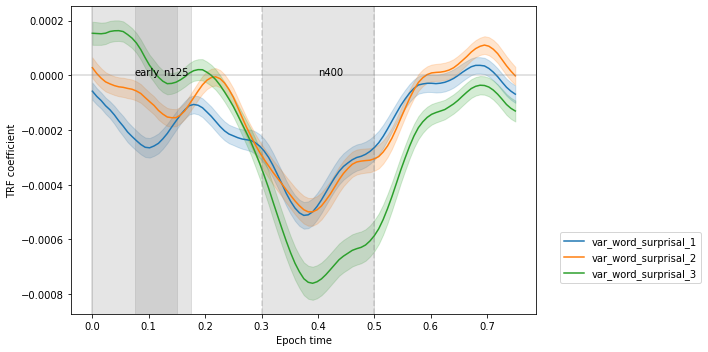

In [78]:
f, ax = plt.subplots(figsize=(10, 5))
plot_trf_coefficients(coef_agg_df, errorbar="se", predictor_match_patterns=[test_features[0]], ax=ax)

for troi, tstart, tend, _ in temporal_rois:
    ax.axvspan(tstart, tend, alpha=0.2, color="gray")
    ax.text((tend + tstart) / 2, 0, troi)
    
None

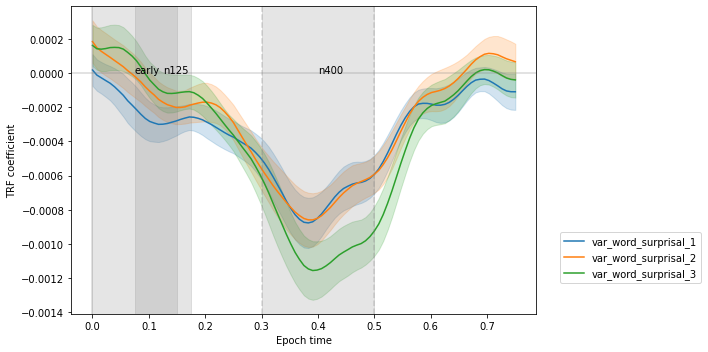

In [79]:
f, ax = plt.subplots(figsize=(10, 5))
plot_trf_coefficients(coef_agg_df[coef_agg_df.sensor == "A19"], errorbar="se", predictor_match_patterns=[test_features[0]], ax=ax)

for troi, tstart, tend, _ in temporal_rois:
    ax.axvspan(tstart, tend, alpha=0.2, color="gray")
    ax.text((tend + tstart) / 2, 0, troi)
    
None

## Visualize curves

In [80]:
surprisal_quantile_means = -df.groupby("recognition_quantile").word_surprisal.mean()
surprisal_quantile_means

recognition_quantile
0    1.337720
1    2.985122
2    4.867740
Name: word_surprisal, dtype: float32

In [81]:
df["word_probability"] = 2 ** df.word_surprisal
probability_quantile_means = df.groupby("recognition_quantile").word_probability.mean()
probability_quantile_means

recognition_quantile
0    0.552296
1    0.243671
2    0.119510
Name: word_probability, dtype: float32

In [82]:
roi_df = {}

for label, tstart, tend, agg in temporal_rois:
    sub_comb_df = coef_agg_df[coef_agg_df.epoch_time.between(tstart, tend)]
    roi_df[label] = sub_comb_df.loc[sub_comb_df.groupby(["subject", "sensor", "predictor_name", "quantile"]).coef.agg(agg)]
    
roi_df = pd.concat(roi_df, names=["toi"])
roi_df["mean_surprisal"] = roi_df["quantile"].map(surprisal_quantile_means)
roi_df["mean_probability"] = roi_df["quantile"].map(probability_quantile_means)
roi_df

base_predictor subject  lag  epoch_time sensor  \
toi                                                                   
n125  329     var_recognition_onset       1   10    0.078125    A19   
      330     var_recognition_onset       1   10    0.078125    A19   
      331     var_recognition_onset       1   10    0.078125    A19   
      59561      var_word_frequency       1   18    0.140625    A19   
      59594      var_word_frequency       1   19    0.148438    A19   
...                             ...     ...  ...         ...    ...   
early 115174     var_word_frequency       9   10    0.078125    D19   
      115175     var_word_frequency       9   10    0.078125    D19   
      173861     var_word_surprisal       9    1    0.007812    D19   
      173862     var_word_surprisal       9    1    0.007812    D19   
      174247     var_word_surprisal       9   13    0.101562    D19   

             sensor_name  quantile      coef           predictor_name  \
toi                                                                     
n125  329            A19         0 -0.000173  var_recognition_onset_1   
      330            A19         1 -0.000164  var_recognition_onset_2   
      331            A19         2 -0.000152  var_recognition_onset_3   
      59561          A19         0 -0.000266     var_word_frequency_1   
      59594          A19         1 -0.000161     var_word_frequency_2   
...                  ...       ...       ...                      ...   
early 115174         D19         1 -0.000477     var_word_frequency_2   
      115175         D19         2 -0.000292     var_word_frequency_3   
      173861         D19         0 -0.000390     var_word_surprisal_1   
      173862         D19         1 -0.000461     var_word_surprisal_2   
      174247         D19         2  0.000476     var_word_surprisal_3   

              mean_surprisal  mean_probability  
toi                                             
n125  329           1.337720          0.552296  
      330           2.985122          0.243671  
      331           4.867740          0.119510  
      59561         1.337720          0.552296  
      59594         2.985122          0.243671  
...                      ...               ...  
early 115174        2.985122          0.243671  
      115175        4.867740          0.119510  
      173861        1.337720          0.552296  
      173862        2.985122          0.243671  
      174247        4.867740          0.119510  

[4104 rows x 11 columns]

In [83]:
# # g = sns.lmplot(data=roi_df.reset_index(), x="mean_surprisal", y="coef", row="toi", hue="subject", scatter=False,
# #                line_kws={"alpha": 0.2}, ci=None, height=6, aspect=2, facet_kws=dict(sharey=False))
# g = sns.FacetGrid(data=roi_df[roi_df.base_predictor == "var_word_surprisal"].reset_index(), col="toi", row="sensor",
#                   height=6, aspect=1, sharey=False)
# g.map_dataframe(sns.lineplot, "mean_surprisal", "coef")
# g.map_dataframe(lambda **kwargs: sns.lineplot(data=kwargs["data"], x="mean_surprisal", y="coef", hue="subject",
#                                               alpha=0.5, errorbar=None))

In [84]:
# # g = sns.lmplot(data=roi_df.reset_index(), x="mean_surprisal", y="coef", row="toi", hue="subject", scatter=False,
# #                line_kws={"alpha": 0.2}, ci=None, height=6, aspect=2, facet_kws=dict(sharey=False))
# g = sns.FacetGrid(data=roi_df[roi_df.base_predictor == "var_word_surprisal"].reset_index(), col="toi", row="sensor",
#                   height=6, aspect=1, sharey=False)
# g.map_dataframe(sns.lineplot, "mean_probability", "coef")
# g.map_dataframe(lambda **kwargs: sns.lineplot(data=kwargs["data"], x="mean_probability", y="coef", hue="subject",
#                                               alpha=0.5, errorbar=None))

## Quantitative test: regression

In [85]:
import statsmodels.api as sm

## Quantitative test: amplitude difference between peaks per quantile

In [86]:
test_df = roi_df.reset_index().set_index(["quantile", "base_predictor", "toi", "subject", "sensor"])
qmin, qmax = 0, roi_df["quantile"].max()
diff_df = test_df.loc[qmax].coef - test_df.loc[qmin].coef

In [87]:
test_df

level_1  lag  epoch_time  \
quantile base_predictor        toi   subject sensor                             
0        var_recognition_onset n125  1       A19         329   10    0.078125   
1        var_recognition_onset n125  1       A19         330   10    0.078125   
2        var_recognition_onset n125  1       A19         331   10    0.078125   
0        var_word_frequency    n125  1       A19       59561   18    0.140625   
1        var_word_frequency    n125  1       A19       59594   19    0.148438   
...                                                      ...  ...         ...   
                               early 9       D19      115174   10    0.078125   
2        var_word_frequency    early 9       D19      115175   10    0.078125   
0        var_word_surprisal    early 9       D19      173861    1    0.007812   
1        var_word_surprisal    early 9       D19      173862    1    0.007812   
2        var_word_surprisal    early 9       D19      174247   13    0.101562   

                                                    sensor_name      coef  \
quantile base_predictor        toi   subject sensor                         
0        var_recognition_onset n125  1       A19            A19 -0.000173   
1        var_recognition_onset n125  1       A19            A19 -0.000164   
2        var_recognition_onset n125  1       A19            A19 -0.000152   
0        var_word_frequency    n125  1       A19            A19 -0.000266   
1        var_word_frequency    n125  1       A19            A19 -0.000161   
...                                                         ...       ...   
                               early 9       D19            D19 -0.000477   
2        var_word_frequency    early 9       D19            D19 -0.000292   
0        var_word_surprisal    early 9       D19            D19 -0.000390   
1        var_word_surprisal    early 9       D19            D19 -0.000461   
2        var_word_surprisal    early 9       D19            D19  0.000476   

                                                              predictor_name  \
quantile base_predictor        toi   subject sensor                            
0        var_recognition_onset n125  1       A19     var_recognition_onset_1   
1        var_recognition_onset n125  1       A19     var_recognition_onset_2   
2        var_recognition_onset n125  1       A19     var_recognition_onset_3   
0        var_word_frequency    n125  1       A19        var_word_frequency_1   
1        var_word_frequency    n125  1       A19        var_word_frequency_2   
...                                                                      ...   
                               early 9       D19        var_word_frequency_2   
2        var_word_frequency    early 9       D19        var_word_frequency_3   
0        var_word_surprisal    early 9       D19        var_word_surprisal_1   
1        var_word_surprisal    early 9       D19        var_word_surprisal_2   
2        var_word_surprisal    early 9       D19        var_word_surprisal_3   

                                                     mean_surprisal  \
quantile base_predictor        toi   subject sensor                   
0        var_recognition_onset n125  1       A19           1.337720   
1        var_recognition_onset n125  1       A19           2.985122   
2        var_recognition_onset n125  1       A19           4.867740   
0        var_word_frequency    n125  1       A19           1.337720   
1        var_word_frequency    n125  1       A19           2.985122   
...                                                             ...   
                               early 9       D19           2.985122   
2        var_word_frequency    early 9       D19           4.867740   
0        var_word_surprisal    early 9       D19           1.337720   
1        var_word_surprisal    early 9       D19           2.985122   
2        var_word_surprisal    early 9       D19           4.867740   

                                

In [88]:
diff_df

base_predictor         toi    subject  sensor
var_recognition_onset  n125   1        A19       0.000021
var_word_frequency     n125   1        A19       0.000022
var_word_surprisal     n125   1        A19      -0.000083
var_recognition_onset  n125   1        A7       -0.000056
var_word_frequency     n125   1        A7       -0.000049
                                                   ...   
                       early  9        C32      -0.000087
var_word_surprisal     early  9        C32       0.000169
var_recognition_onset  early  9        D19      -0.000239
var_word_frequency     early  9        D19      -0.000093
var_word_surprisal     early  9        D19       0.000867
Name: coef, Length: 1368, dtype: float32

### Bootstrap evaluation

In [89]:
diff_df.loc["var_word_surprisal"] \
    .groupby(["toi", "sensor"]).apply(lambda rows: np.quantile(sns.algorithms.bootstrap(rows.values), (.025, 0.975)))

toi    sensor
early  A19          [6.592825211555464e-05, 0.0004573090649500954]
       A7         [-0.0002024043849814916, 0.00038591755655943406]
       B22           [0.000296600244473666, 0.0006549475758220068]
       B4          [-4.617557260644389e-05, 0.0007536236851592547]
       C10         [0.00024256910219264683, 0.0007204838111647404]
       C22          [0.00018182148050982505, 0.000640739730442874]
       C32          [0.0001330842493189266, 0.0005375696142436936]
       D19          [0.0002550027274992317, 0.0006979681784287095]
n125   A19          [5.552059865294723e-05, 0.0003821144768153317]
       A7          [5.298756941556349e-05, 0.00029472349560819564]
       B22         [0.00019919837613997516, 0.0004459355208382476]
       B4          [9.870513786154333e-05, 0.00032493927647010424]
       C10         [0.00022582978890568485, 0.0004745368896692525]
       C22         [3.6022455606143926e-05, 0.0003188771595887373]
       C32         [5.9726166455220664e-05, 0.00

In [90]:
bootstrap_df = diff_df.loc["var_word_surprisal"] \
    .groupby(["sensor", "toi"]).apply(lambda rows: pd.Series(sns.algorithms.bootstrap(rows.values))).droplevel(-1).reset_index()

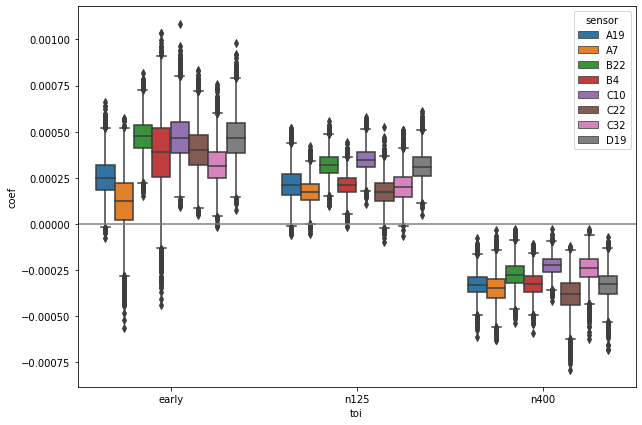

In [91]:
f, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=bootstrap_df, x="toi", y="coef", hue="sensor", ax=ax)
ax.axhline(0, color="gray")

### t-test

In [92]:
diff_df.groupby(["base_predictor", "toi"]).apply(lambda xs: st.ttest_1samp(xs, 0)).sort_values()

base_predictor         toi  
var_word_surprisal     n400       (-12.099558795742853, 5.4744907290079e-24)
var_word_frequency     n400     (-9.992752798904885, 2.3114957920248685e-18)
var_recognition_onset  early     (-5.223716711899568, 5.727849513760745e-07)
                       n400      (-4.157689856605815, 5.369779239140438e-05)
                       n125        (-1.2421872645487118, 0.2160932489922622)
var_word_frequency     early      (4.031742209915728, 8.756311413086505e-05)
                       n125       (4.578791187624348, 9.709314201056267e-06)
var_word_surprisal     early     (7.707769237735448, 1.5874125315138692e-12)
                       n125       (9.69821801104842, 1.3757202334106578e-17)
Name: coef, dtype: object

In [93]:
ptests = diff_df.groupby(["base_predictor", "toi", "sensor"]).apply(lambda xs: st.ttest_1samp(xs, 0))

In [94]:
# Peek ONLY at the cases which we selected from the clustering analysis.
ptests.loc[a_priori_interest]

base_predictor      toi    sensor
var_word_surprisal  n125   D19        (4.212755313931063, 0.0005231839117223286)
                           C10       (5.442049475870561, 3.6030820316757886e-05)
                    n400   A19       (-5.144642432968741, 6.795834398690991e-05)
                    early  C10        (3.775457534323112, 0.0013851063626927015)
Name: coef, dtype: object

## Quantitative test: latency-to-peak difference per quantile

In [95]:
latency_df = roi_df.reset_index().set_index(["base_predictor", "toi", "sensor", "quantile", "subject"]).sort_index()

In [96]:
# Get just the tROIs+sensors+features of interest
latency_df = pd.concat({
    quantile: pd.concat(
        [latency_df.loc[(predictor, toi, sensor, quantile)] for predictor, toi, sensor in a_priori_interest],
        names=["predictor", "toi", "sensor", "subject"], keys=a_priori_interest).sort_index()
    for quantile in [qmin, qmax]
}, names=["quantile"])
latency_df

level_1  lag  epoch_time  \
quantile predictor          toi   sensor subject                             
0        var_word_surprisal early C10    1         118577   19    0.148438   
                                         10        121649   18    0.140625   
                                         11        124657   15    0.117188   
                                         12        127537    8    0.062500   
                                         13        130385    0    0.000000   
...                                                   ...  ...         ...   
2        var_word_surprisal n400  A19    5         163339   60    0.468750   
                                         6         166219   53    0.414062   
                                         7         169227   50    0.390625   
                                         8         172363   51    0.398438   
                                         9         175147   41    0.320312   

                                                 sensor_name      coef  \
quantile predictor          toi   sensor subject                         
0        var_word_surprisal early C10    1               C10  0.000500   
                                         10              C10  0.000447   
                                         11              C10 -0.000837   
                                         12              C10 -0.000532   
                                         13              C10  0.000200   
...                                                      ...       ...   
2        var_word_surprisal n400  A19    5               A19 -0.001069   
                                         6               A19 -0.001036   
                                         7               A19 -0.001496   
                                         8               A19 -0.002247   
                                         9               A19 -0.001644   

                                                        predictor_name  \
quantile predictor          toi   sensor subject                         
0        var_word_surprisal early C10    1        var_word_surprisal_1   
                                         10       var_word_surprisal_1   
                                         11       var_word_surprisal_1   
                                         12       var_word_surprisal_1   
                                         13       var_word_surprisal_1   
...                                                                ...   
2        var_word_surprisal n400  A19    5        var_word_surprisal_3   
                                         6        var_word_surprisal_3   
                                         7        var_word_surprisal_3   
                                         8        var_word_surprisal_3   
                                         9        var_word_surprisal_3   

                                                  mean_surprisal  \
quantile predictor          toi   sensor subject                   
0        var_word_surprisal early C10    1               1.33772   
                                         10              1.33772   
                                         11              1.33772   
                                         12              1.33772   
                                         13              1.33772   
...                                                          ...   
2        var_word_surprisal n400  A19    5               4.86774   
                                         6               4.86774   
                                         7               4.86774   
                                         8               4.86774   
                                         9               4.86774   

                                                  mean_probability  
quantile predictor          toi   sensor subject                    
0        var_word_surprisal early C10    1                0.552296  
                 

In [106]:
latency_diff_df = ((latency_df.loc[qmax].lag - latency_df.loc[qmin].lag) / pipe.encoder.sfreq).rename("delta_t")
latency_diff_df.head()

predictor           toi    sensor  subject
var_word_surprisal  early  C10     1          0.000000
                                   10        -0.023438
                                   11        -0.078125
                                   12        -0.062500
                                   13         0.078125
Name: delta_t, dtype: float64

In [107]:
latency_diff_plot_df = latency_diff_df.reset_index()
latency_diff_plot_df["label"] = latency_diff_plot_df.predictor.str.cat([latency_diff_plot_df.toi, latency_diff_plot_df.sensor], sep=" ")

In [108]:
latency_diff_plot_df.head()

,predictor,toi,sensor,subject,delta_t,label
0,var_word_surprisal,early,C10,1,0.000000,var_word_surprisal early C10
1,var_word_surprisal,early,C10,10,-0.023438,var_word_surprisal early C10
2,var_word_surprisal,early,C10,11,-0.078125,var_word_surprisal early C10
3,var_word_surprisal,early,C10,12,-0.062500,var_word_surprisal early C10
4,var_word_surprisal,early,C10,13,0.078125,var_word_surprisal early C10


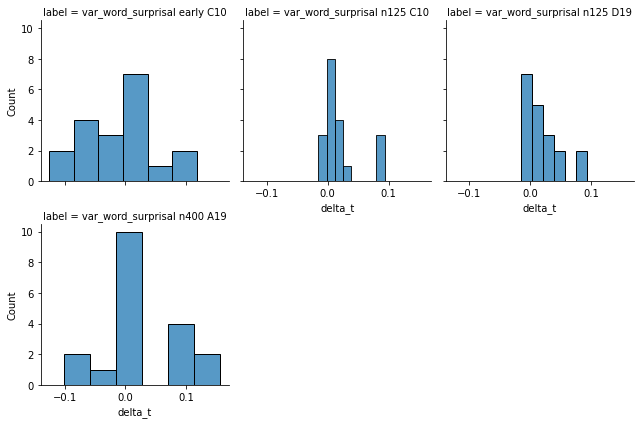

In [109]:
g = sns.FacetGrid(data=latency_diff_plot_df, col="label", col_wrap=3)
g.map(sns.histplot, "delta_t")

In [110]:
latency_diff_df.groupby(["predictor", "toi", "sensor"]).apply(
    lambda toi_rows: st.ttest_1samp(toi_rows, popmean=0))

predictor           toi    sensor
var_word_surprisal  early  C10       (-1.0578627365978484, 0.30410900004245905)
                    n125   C10        (2.2575377095559475, 0.03663594867061983)
                           D19        (3.0753463803927366, 0.00652146469347338)
                    n400   A19        (1.3906219793143986, 0.18129522425585098)
Name: delta_t, dtype: object